In [1]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

/Users/windflower715/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_json("renthopnew1.json" )
df.head()

,address,bath,beds,features,hopscore,monthlyrent,neighborhood,sqft,train
0,2BR at 530 West 50th Street,1 Bath,2 Beds,"[Featured, Exclusive, Cats Allowed, Dogs Allow...",100.0,"$2,366",Midtown Manhattan,720 Sqft,0.42 mi
1,1BR at 524 West 50th Street,1 Bath,1 Bed,"[Featured, All Day Sunshine, Renovated Very Qu...",100.0,"$2,395",Midtown Manhattan,None,0.41 mi
2,1BR at 519 West 48th Street,1 Bath,1 Bed,"[Featured, 1 months rent brokers commission, C...",100.0,"$2,149",Midtown Manhattan,600 Sqft,0.41 mi
3,1BR at 320 East 50th St,1 Bath,1 Bed,[Featured],100.0,"$2,725",Midtown East,None,0.23 mi
4,1BR at 50 West 34th St,1 Bath,1 Bed,"[No Fee, Featured, Doorman, Elevator, Pre-War,...",100.0,"$3,400",Midtown Manhattan,None,0.03 mi


In [3]:
#right now we have multiple neighborhoods overlapping each other, let's combine them into upper east, upper west
#-- all midtown, all downtown, uptown manhattan (everything uptown except upper east and upper west)
df['neighborhood'].value_counts()

Midtown Manhattan     6296
Downtown Manhattan    5844
Upper Manhattan       3207
Upper East Side       1727
Upper West Side       1074
Midtown East           942
Kips Bay               720
East Village           404
West Harlem            218
Washington Heights     152
Manhattan               62
SoHo                    34
Central Harlem          11
Long Island City         4
Name: neighborhood, dtype: int64

In [4]:
#combine different neighborhoods
df.loc[df['neighborhood'].str.contains('Midtown East'), 'neighborhood'] = 'Midtown Manhattan'
df.loc[df['neighborhood'].str.contains('Midtown East'), 'neighborhood'] = 'Midtown Manhattan'
df.loc[df['neighborhood'].str.contains('Upper Manhattan'), 'neighborhood'] = 'Midtown Manhattan'
df.loc[df['neighborhood'].str.contains('Kips Bay'), 'neighborhood'] = 'Midtown Manhattan'
df.loc[df['neighborhood'].str.contains('East Village'), 'neighborhood'] = 'Downtown Manhattan'
df.loc[df['neighborhood'].str.contains('West Harlem'), 'neighborhood'] = 'Uptown Manhattan'
df.loc[df['neighborhood'].str.contains('Washington Heights'), 'neighborhood'] = 'Uptown Manhattan'
df.loc[df['neighborhood'].str.contains('SoHo'), 'neighborhood'] = 'Downtown Manhattan'
df.loc[df['neighborhood'].str.contains('Central Harlem'), 'neighborhood'] = 'Uptown Manhattan'


In [5]:
#drop odd neighborhoods 
df =df[df['neighborhood'] != 'Long Island City']
df =df[df['neighborhood'] != 'Manhattan']

In [6]:
df['neighborhood'].unique()
#cleaned all the neighborhoods


array(['Midtown Manhattan', 'Downtown Manhattan', 'Upper East Side',
       'Upper West Side', 'Uptown Manhattan'], dtype=object)

In [7]:
#take a look at the all the features available in scraped listings 
features =list(df.loc[:,'features'])
lat_list = [item for sublist in features for item in sublist]
allfeatures = list([i.strip().lower() for i in lat_list])
allfeatures[:10]

['featured',
 'exclusive',
 'cats allowed',
 'dogs allowed',
 'common outdoor space',
 'hardwood floors',
 'light',
 'high ceilings bike storage in the courtyard',
 'featured',
 'all day sunshine']

In [8]:
#build a list of features that I want to include in my model as featureslist
#convert features column into a dummy variable columns
featureslist = ['Doorman', 'Elevator', 'Laundry In Building', 'Cats Allowed', 'Dogs Allowed', 'Light', 'Storage','Laundry In Unit','Live In Super','Parking','Garden','Gym','Swimming Pool']
df[featureslist]=pd.DataFrame(list(df.features.apply(lambda x: [1 if f in x else 0 for f in featureslist])),index=df.index)
df.columns

Index(['address', 'bath', 'beds', 'features', 'hopscore', 'monthlyrent',
       'neighborhood', 'sqft', 'train', 'Doorman', 'Elevator',
       'Laundry In Building', 'Cats Allowed', 'Dogs Allowed', 'Light',
       'Storage', 'Laundry In Unit', 'Live In Super', 'Parking', 'Garden',
       'Gym', 'Swimming Pool'],
      dtype='object')

In [9]:
#turn neighborhoods into dummy variables
neighborhoodlist = ['Midtown Manhattan', 'Downtown Manhattan', 'Upper East Side','Upper West Side', 'Uptown Manhattan']
df[neighborhoodlist]=pd.DataFrame(list(df.neighborhood.apply(lambda x: [1 if f in x else 0 for f in neighborhoodlist])),index=df.index)
df.columns

Index(['address', 'bath', 'beds', 'features', 'hopscore', 'monthlyrent',
       'neighborhood', 'sqft', 'train', 'Doorman', 'Elevator',
       'Laundry In Building', 'Cats Allowed', 'Dogs Allowed', 'Light',
       'Storage', 'Laundry In Unit', 'Live In Super', 'Parking', 'Garden',
       'Gym', 'Swimming Pool', 'Midtown Manhattan', 'Downtown Manhattan',
       'Upper East Side', 'Upper West Side', 'Uptown Manhattan'],
      dtype='object')

In [10]:
#drop all the rows, where the it doesn't have a sqft value and reset index
df = df.dropna()
df.reset_index().head()

,index,address,bath,beds,features,hopscore,monthlyrent,neighborhood,sqft,train,...,Live In Super,Parking,Garden,Gym,Swimming Pool,Midtown Manhattan,Downtown Manhattan,Upper East Side,Upper West Side,Uptown Manhattan
0,0,2BR at 530 West 50th Street,1 Bath,2 Beds,"[Featured, Exclusive, Cats Allowed, Dogs Allow...",100.0,"$2,366",Midtown Manhattan,720 Sqft,0.42 mi,...,0,0,0,0,0,1,0,0,0,0
1,2,1BR at 519 West 48th Street,1 Bath,1 Bed,"[Featured, 1 months rent brokers commission, C...",100.0,"$2,149",Midtown Manhattan,600 Sqft,0.41 mi,...,0,0,0,0,0,1,0,0,0,0
2,5,3BR at E. 20s Street,1 Bath,3 Beds,"[No Fee, Featured, Cats Allowed, Dogs Allowed,...",100.0,"$4,300",Midtown Manhattan,"1,000 Sqft",0.30 mi,...,0,0,0,0,0,1,0,0,0,0
3,10,3BR at 1297 Lexington,2 Baths,3 Beds,"[No Fee, Featured]",100.0,"$4,500",Midtown Manhattan,"1,000 Sqft",0.07 mi,...,0,0,0,0,0,1,0,0,0,0
4,19,4BR at east 20's,2 Baths,4 Beds,"[No Fee, Featured, Parking Space, Cats Allowed...",100.0,"$5,000",Midtown Manhattan,"1,500 Sqft",0.35 mi,...,0,0,0,0,0,1,0,0,0,0


In [11]:
#cleaning all data and convert into floats
df['bath']=df['bath'].map(lambda x: float(x.split()[0]))
df['beds'] = df['beds'].map(lambda x: float(x.split()[0]))
df['address'] = df['address'].map(lambda x: x.split('at')[1])
df['monthlyrent'] = df['monthlyrent'].map(lambda x: float(x.split('$')[1].replace(',','')))
df['sqft'] = df['sqft'].map(lambda x: float(x.split()[0].replace(',','')))
df['train']=df['train'].map(lambda x: float(x.split()[0]))
df.head()

,address,bath,beds,features,hopscore,monthlyrent,neighborhood,sqft,train,Doorman,...,Live In Super,Parking,Garden,Gym,Swimming Pool,Midtown Manhattan,Downtown Manhattan,Upper East Side,Upper West Side,Uptown Manhattan
0,530 West 50th Street,1.0,2.0,"[Featured, Exclusive, Cats Allowed, Dogs Allow...",100.0,2366.0,Midtown Manhattan,720.0,0.42,0,...,0,0,0,0,0,1,0,0,0,0
2,519 West 48th Street,1.0,1.0,"[Featured, 1 months rent brokers commission, C...",100.0,2149.0,Midtown Manhattan,600.0,0.41,0,...,0,0,0,0,0,1,0,0,0,0
5,E. 20s Street,1.0,3.0,"[No Fee, Featured, Cats Allowed, Dogs Allowed,...",100.0,4300.0,Midtown Manhattan,1000.0,0.30,1,...,0,0,0,0,0,1,0,0,0,0
10,1297 Lexington,2.0,3.0,"[No Fee, Featured]",100.0,4500.0,Midtown Manhattan,1000.0,0.07,0,...,0,0,0,0,0,1,0,0,0,0
19,east 20's,2.0,4.0,"[No Fee, Featured, Parking Space, Cats Allowed...",100.0,5000.0,Midtown Manhattan,1500.0,0.35,1,...,0,0,0,0,0,1,0,0,0,0


In [12]:
#strip the white space in the column names 
df = df.rename(columns={'Laundry In Building': 'Laundryinbuilding', 'Cats Allowed': 'Catsallowed','Dogs Allowed':'Dogsallowed','Laundry In Unit':'Laundryinunit','Live In Super':'Liveinsuper','Swimming Pool':'Swimmingpool'
                       ,'Midtown Manhattan':'Midtown','Downtown Manhattan':'Downtown','Upper East Side':'Upper_east','Upper West Side':'Upper_west','Uptown Manhattan':'Uptown'})
df.head()

,address,bath,beds,features,hopscore,monthlyrent,neighborhood,sqft,train,Doorman,...,Liveinsuper,Parking,Garden,Gym,Swimmingpool,Midtown,Downtown,Upper_east,Upper_west,Uptown
0,530 West 50th Street,1.0,2.0,"[Featured, Exclusive, Cats Allowed, Dogs Allow...",100.0,2366.0,Midtown Manhattan,720.0,0.42,0,...,0,0,0,0,0,1,0,0,0,0
2,519 West 48th Street,1.0,1.0,"[Featured, 1 months rent brokers commission, C...",100.0,2149.0,Midtown Manhattan,600.0,0.41,0,...,0,0,0,0,0,1,0,0,0,0
5,E. 20s Street,1.0,3.0,"[No Fee, Featured, Cats Allowed, Dogs Allowed,...",100.0,4300.0,Midtown Manhattan,1000.0,0.30,1,...,0,0,0,0,0,1,0,0,0,0
10,1297 Lexington,2.0,3.0,"[No Fee, Featured]",100.0,4500.0,Midtown Manhattan,1000.0,0.07,0,...,0,0,0,0,0,1,0,0,0,0
19,east 20's,2.0,4.0,"[No Fee, Featured, Parking Space, Cats Allowed...",100.0,5000.0,Midtown Manhattan,1500.0,0.35,1,...,0,0,0,0,0,1,0,0,0,0


In [13]:
df = df.drop('features', axis = 1 )
df.head()

,address,bath,beds,hopscore,monthlyrent,neighborhood,sqft,train,Doorman,Elevator,...,Liveinsuper,Parking,Garden,Gym,Swimmingpool,Midtown,Downtown,Upper_east,Upper_west,Uptown
0,530 West 50th Street,1.0,2.0,100.0,2366.0,Midtown Manhattan,720.0,0.42,0,0,...,0,0,0,0,0,1,0,0,0,0
2,519 West 48th Street,1.0,1.0,100.0,2149.0,Midtown Manhattan,600.0,0.41,0,0,...,0,0,0,0,0,1,0,0,0,0
5,E. 20s Street,1.0,3.0,100.0,4300.0,Midtown Manhattan,1000.0,0.30,1,1,...,0,0,0,0,0,1,0,0,0,0
10,1297 Lexington,2.0,3.0,100.0,4500.0,Midtown Manhattan,1000.0,0.07,0,0,...,0,0,0,0,0,1,0,0,0,0
19,east 20's,2.0,4.0,100.0,5000.0,Midtown Manhattan,1500.0,0.35,1,1,...,0,0,0,0,0,1,0,0,0,0


In [14]:
#pickle cleaned dataframe 
import pickle 
with open('cleaneddf.pkl','wb') as picklefile:
    pickle.dump(df,picklefile)

In [15]:
with open('cleaneddf.pkl','rb') as picklefile:
    cleaneddf = pickle.load(picklefile)
cleaneddf.head()

,address,bath,beds,hopscore,monthlyrent,neighborhood,sqft,train,Doorman,Elevator,...,Liveinsuper,Parking,Garden,Gym,Swimmingpool,Midtown,Downtown,Upper_east,Upper_west,Uptown
0,530 West 50th Street,1.0,2.0,100.0,2366.0,Midtown Manhattan,720.0,0.42,0,0,...,0,0,0,0,0,1,0,0,0,0
2,519 West 48th Street,1.0,1.0,100.0,2149.0,Midtown Manhattan,600.0,0.41,0,0,...,0,0,0,0,0,1,0,0,0,0
5,E. 20s Street,1.0,3.0,100.0,4300.0,Midtown Manhattan,1000.0,0.30,1,1,...,0,0,0,0,0,1,0,0,0,0
10,1297 Lexington,2.0,3.0,100.0,4500.0,Midtown Manhattan,1000.0,0.07,0,0,...,0,0,0,0,0,1,0,0,0,0
19,east 20's,2.0,4.0,100.0,5000.0,Midtown Manhattan,1500.0,0.35,1,1,...,0,0,0,0,0,1,0,0,0,0


# OLS with Statsmodels 

In [16]:
#let's take a quick look at the correlation 
df.corr()

,bath,beds,hopscore,monthlyrent,sqft,train,Doorman,Elevator,Laundryinbuilding,Catsallowed,...,Liveinsuper,Parking,Garden,Gym,Swimmingpool,Midtown,Downtown,Upper_east,Upper_west,Uptown
bath,1.000000,0.660745,-0.085157,0.723394,0.769651,0.007304,0.126419,0.075288,-0.020838,-0.024332,...,0.034893,0.005479,-0.024263,0.034035,0.136551,0.001935,-0.041074,0.031579,0.076305,-0.079141
beds,0.660745,1.000000,-0.022378,0.490341,0.636666,0.026376,-0.003891,0.008203,0.017814,-0.104202,...,0.134514,-0.001185,-0.001530,0.031385,0.058736,0.011358,-0.041511,0.054653,-0.019391,0.008511
hopscore,-0.085157,-0.022378,1.000000,-0.112998,-0.080821,0.037120,-0.121405,-0.127558,0.043063,0.101978,...,-0.014987,0.008104,-0.022813,0.005199,-0.073957,0.027593,0.003723,-0.027272,-0.038073,0.016817
monthlyrent,0.723394,0.490341,-0.112998,1.000000,0.817059,-0.049364,0.110025,0.065193,-0.124683,0.043635,...,0.003304,-0.001701,-0.016475,0.026683,0.166869,-0.038136,0.044654,-0.026162,0.080745,-0.096342
sqft,0.769651,0.636666,-0.080821,0.817059,1.000000,-0.019722,0.057049,0.060385,-0.055801,-0.011963,...,0.029430,-0.000748,-0.011481,0.046085,0.107778,-0.001606,-0.029472,0.018184,0.062176,-0.049035
train,0.007304,0.026376,0.037120,-0.049364,-0.019722,1.000000,0.010579,-0.027878,-0.007997,-0.090243,...,-0.013368,0.009501,0.041635,0.018346,0.148236,0.225740,-0.289955,0.020827,0.076668,-0.043586
Doorman,0.126419,-0.003891,-0.121405,0.110025,0.057049,0.010579,1.000000,0.583045,0.342794,0.131590,...,0.036627,0.021388,0.006270,0.041199,0.207358,0.003617,0.016699,-0.018964,0.078201,-0.167965
Elevator,0.075288,0.008203,-0.127558,0.065193,0.060385,-0.027878,0.583045,1.000000,0.420072,0.120262,...,0.056422,0.016772,0.021662,-0.042244,0.118906,-0.023207,0.025782,-0.044079,0.056559,-0.003388
Laundryinbuilding,-0.020838,0.017814,0.043063,-0.124683,-0.055801,-0.007997,0.342794,0.420072,1.000000,-0.015982,...,0.079745,0.006150,0.039553,-0.017294,0.081627,-0.021219,0.043764,0.025170,-0.051372,-0.033029
Catsallowed,-0.024332,-0.104202,0.101978,0.043635,-0.011963,-0.090243,0.131590,0.120262,-0.015982,1.000000,...,-0.024592,0.024625,0.031804,0.014670,0.027094,-0.062163,0.122497,-0.121126,0.022198,0.052564


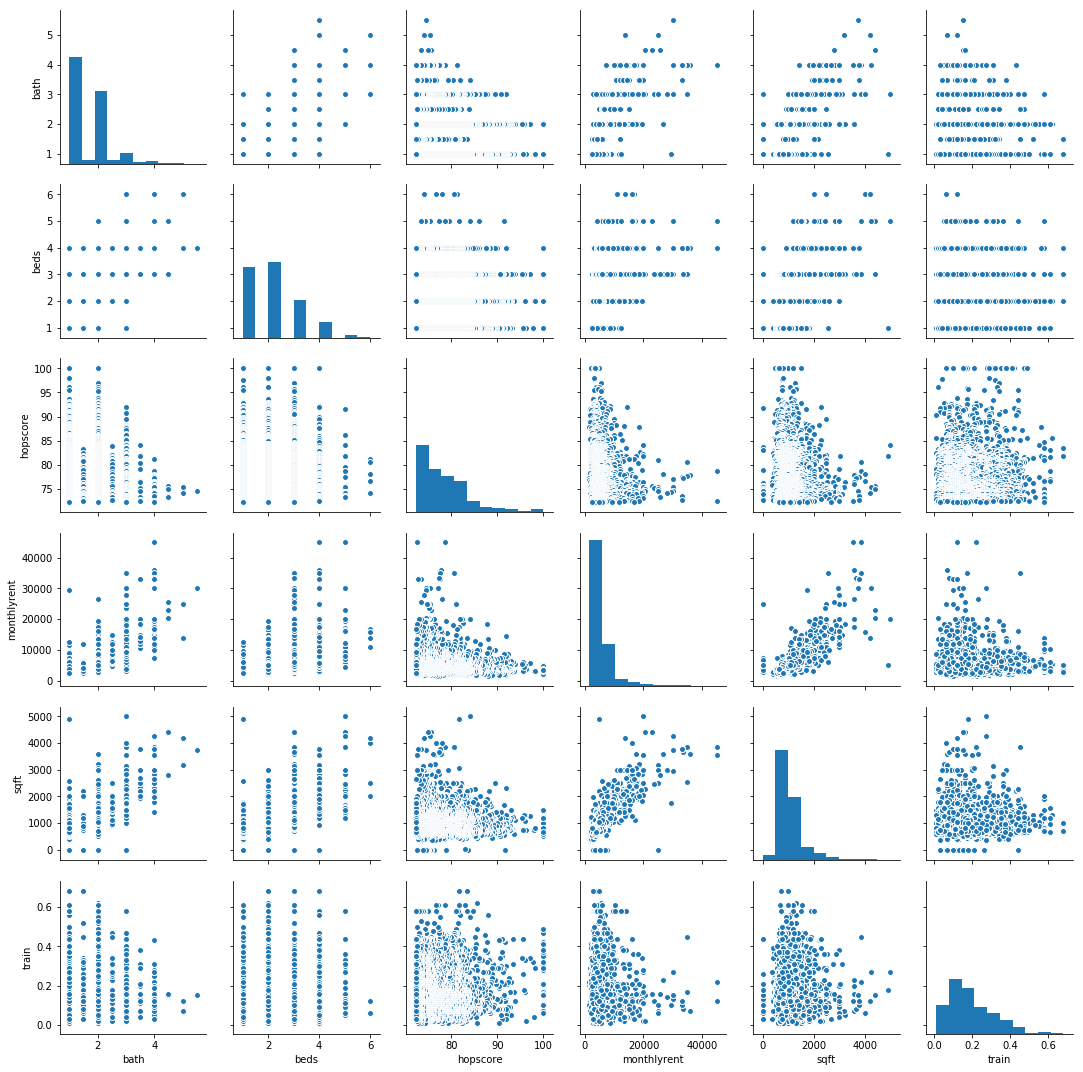

In [17]:
#examin distribution of numerical variables
dfnum = df[['address','bath','beds','hopscore','monthlyrent','sqft','train']]
sns.pairplot(dfnum)

In [18]:
lm = smf.ols(' monthlyrent~ bath + beds + hopscore + sqft + train+ Doorman +Elevator + Laundryinbuilding+ Catsallowed + Dogsallowed+Light+Storage+Liveinsuper+Parking+Garden+Gym+Swimmingpool+Midtown+Downtown+Upper_east+Upper_west+Uptown', data=df)
# Fit the model
fit = lm.fit()
# Print summary statistics of the model's performance
fit.summary()

#from the pvalue,  we could see that elevator, cats/dogs and storage 
#is not significant features for an apartment's rental price

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            monthlyrent   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     287.1
Date:                Tue, 27 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:13:21   Log-Likelihood:                -20725.
No. Observations:                2292   AIC:                         4.149e+04
Df Residuals:                    2270   BIC:                         4.162e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           326.9723    582.607      0.561      0.575    -815.525    1469.470
bath               1437.4362    105.442     13.632      0.000    1230.663    1644.210
beds               -322.7849     63.145     -5.112      0.000    -446.613    -198.957
hopscore            -21.1760      8.548     -2.477      0.013     -37.939      -4.413
sqft                  4.7795      0.131     36.456      0.000       4.522       5.037
train              -993.7430    387.258     -2.566      0.010   -1753.160    -234.326
Doorman             389.6100    128.741      3.026      0.003     137.148     642.072
Elevator             41.2856    148.154      0.279      0.781    -249.246     331.817
Laundryinbuilding  -672.6858    104.591     -6.432      0.000    -877.789    -467.582
Catsallowed         -16.9755    204.971     -0.083      0.934    -418.925     384.974
Dogsallowed         182.6725    201.130      0.908      0.364    -211.745     577.090
Light              -541.2698    102.324     -5.290      0.000    -741.927    -340.612
Storage             149.7497    152.107      0.985      0.325    -148.533     448.033
Liveinsuper         -55.2035    255.821     -0.216      0.829    -556.872     446.465
Parking            -507.3911   1199.554     -0.423      0.672   -2859.727    1844.945
Garden               97.2391    926.531      0.105      0.916   -1719.698    1914.176
Gym                -577.8449    438.444     -1.318      0.188   -1437.638     281.949
Swimmingpool        882.4709    133.353      6.618      0.000     620.965    1143.977
Midtown             184.2601    145.227      1.269      0.205    -100.532     469.052
Downtown            718.0454    150.321      4.777      0.000     423.264    1012.827
Upper_east         -154.9387    171.573     -0.903      0.367    -491.395     181.517
Upper_west          330.9907    198.196      1.670      0.095     -57.673     719.655
Uptown             -751.3852    294.955     -2.547      0.011   -1329.795    -172.975
==============================================================================
Omnibus:                     1884.251   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           125340.381
Skew:                           3.411   Prob(JB):                         0.00
Kurtosis:                      38.580   Cond. No.                     7.61e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.77e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

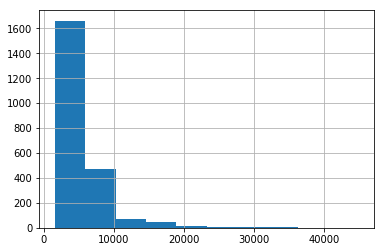

In [19]:
#take a look at the distribtion of my Y ~ monthly rent price

df.monthlyrent.hist()

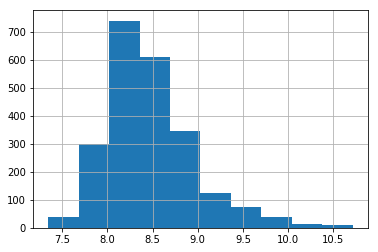

In [20]:
#the sitribution of monthly rent y is skewed, need to do a log transformation
dftrans = df 
dftrans['logmonthlyrent'] = np.log(dftrans['monthlyrent'])
dftrans.logmonthlyrent.hist()

In [21]:
#run another regression on the transformed datafram, drop the insignificant features include 
lm1 = smf.ols('logmonthlyrent~ bath + beds + hopscore + sqft + train+ Doorman + Laundryinbuilding+Light+Swimmingpool', data=dftrans)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()
#it seams that we have a slight higher Rsquared now. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         logmonthlyrent   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     832.3
Date:                Tue, 27 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:14:04   Log-Likelihood:                 77.220
No. Observations:                2292   AIC:                            -134.4
Df Residuals:                    2282   BIC:                            -77.07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.8567      0.078    100.740      0.000       7.704       8.010
bath                  0.2453      0.012     20.532      0.000       0.222       0.269
beds                  0.0071      0.007      1.005      0.315      -0.007       0.021
hopscore             -0.0039      0.001     -4.101      0.000      -0.006      -0.002
sqft                  0.0005   1.49e-05     31.168      0.000       0.000       0.000
train                -0.1461      0.042     -3.494      0.000      -0.228      -0.064
Doorman               0.1697      0.012     13.658      0.000       0.145       0.194
Laundryinbuilding    -0.1114      0.011     -9.842      0.000      -0.134      -0.089
Light                -0.0596      0.011     -5.334      0.000      -0.082      -0.038
Swimmingpool          0.0759      0.015      5.064      0.000       0.046       0.105
==============================================================================
Omnibus:                      313.881   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2018.181
Skew:                           0.466   Prob(JB):                         0.00
Kurtosis:                       7.502   Cond. No.                     1.93e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

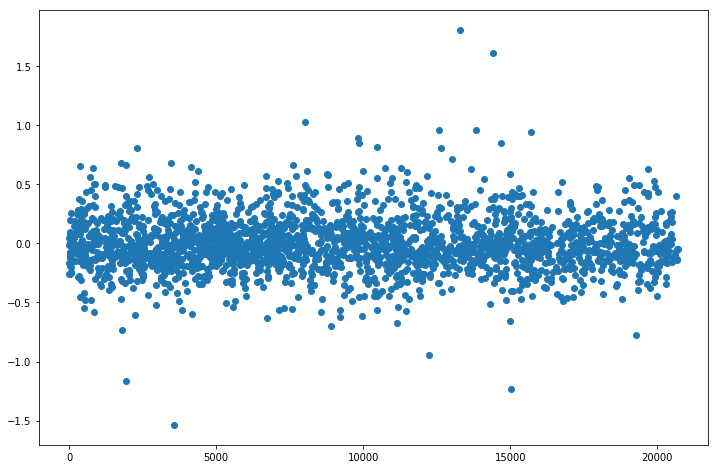

In [22]:
#examine the residual plot to test for homoskedasticity assumption
fit1.resid.plot(style='o', figsize=(12,8))

# Train test split

In [23]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression

/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
#define our X and y before we do regression
X = dftrans[[ 'bath', 'beds', 'hopscore','sqft', 'train', 'Doorman', 'Laundryinbuilding','Light', 'Storage', 'Laundryinunit','Catsallowed','Dogsallowed']]
y = dftrans['logmonthlyrent']

In [25]:
lr = LinearRegression()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.7451432502248022

In [26]:
lr.coef_

array([ 0.21933612, -0.00285612, -0.00277162,  0.00050253, -0.09808645,
        0.16832063, -0.12080818, -0.04451613,  0.03979191,  0.05556206,
       -0.0381697 ,  0.05739181])

In [27]:
lr.intercept_

7.75674814280809

In [28]:
y_pred = lr.predict(X_test)

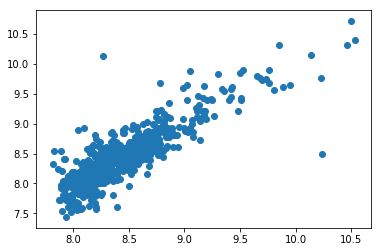

In [29]:
plt.scatter(y_pred, y=y_test)

# KFold

In [30]:
#5 fold 
from sklearn.cross_validation import cross_val_score
reg = LinearRegression()
scores = cross_val_score(reg, X,y, cv = 5,scoring='mean_squared_error')

print(-scores)

[0.05420453 0.04375601 0.0613687  0.07428906 0.04611845]


/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

In [31]:
#use sklearn to do some feature selection here
from sklearn import feature_selection as f_select
est=LinearRegression()
kf=KFold(n=len(X),n_folds=5,shuffle=True)

all_scores=[]

for train,test in kf:
    x_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
#feeding each features separately in to the model to get the p values
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.02: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
# #after running the feature selection, we selected the features where p value is significant
# #These features include ['bath', 'beds', 'hopscore', 'sqft', 'Doorman', 'Laundryinbuilding', 'Storage', 'Laundryinunit']
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
np.mean(all_scores)


0.7569821962757347

# Regularization: preprocessing

In [32]:
#Ridge regression and kfold data prep 
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

In [33]:
dftrans = dftrans.drop(['address'], axis=1)
dftrans.columns
dftrans.drop(['neighborhood'], axis =1, inplace = True)

In [35]:
X = dftrans[['bath', 'beds', 'hopscore','sqft', 'train', 'Doorman', 'Laundryinbuilding','Light',
            'Storage', 'Laundryinunit','Catsallowed','Dogsallowed','Light','Storage', 'Laundryinunit', 
            'Liveinsuper', 'Parking', 'Garden', 'Gym','Swimmingpool','Midtown', 'Downtown',
            'Upper_east', 'Upper_west', 'Uptown']]
y = dftrans['logmonthlyrent']


In [37]:
from sklearn import preprocessing

# normalize features to values between 0 and 1
df_norm=preprocessing.normalize(dftrans,axis=0)

# Ridge 

In [38]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)
rcv = RidgeCV(cv =10)
rcv.fit(X_train, y_train)
rcv.score(X_test,y_test)

0.7802283215095128

In [39]:
#train test split in ridge
alphas = [1e-5, 1e-3,1e-1,0,1,100,10000]

def make_estimator(est, alpha):
    est.alpha = alpha
    model = est.fit(X_train, y_train)
    mse=np.mean((y_test-model.predict(X_test))**2)
    return mse

No handles with labels found to put in legend.
/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
No handles with labels found to put in legend.


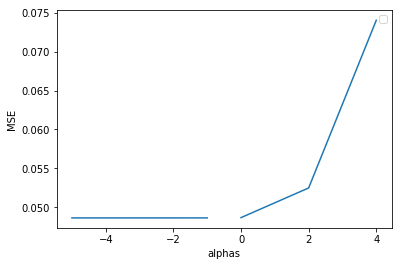

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

all_mse=[]   
for a in alphas: 
    all_mse.append(make_estimator(Ridge(),a))
                   

plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()




# Lasso

In [41]:
from sklearn.linear_model import Lasso

kf = KFold(len(X),n_folds=5, shuffle=True)

all_scores=[]
alphas=[1e-5,1e-3,1e-1,0,1]
r2 = []


for train, test in kf:
    x_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    mse_score=[]
    r=[]
    for a in alphas:
        est=Lasso(alpha=a,tol=0.001)
        est.fit(x_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
        r.append(est.score(x_test,y_test))
            
    all_scores.append(mse_score)
    r2.append(r) #r2 is the r score for all alphas and folds
rs=[np.mean(i) for i in r2]

/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [42]:
np.mean(rs)

0.729601010698066

(0.5, 0.8)

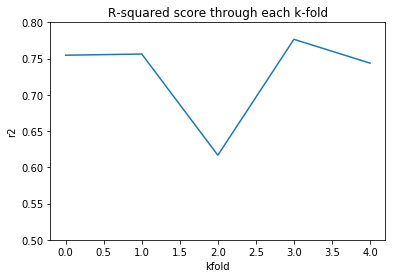

In [44]:
#plot out my r-squared through each folds
plt.plot(rs)
axes = plt.gca()
axes.set_ylim([0,1])
plt.title('R-squared score through each k-fold')
plt.xlabel('kfold')
plt.ylabel('r2')
plt.ylim((0.5,0.8))

In [45]:
np.mean(mse_score)

0.05867106421980994

(0, 0.1)

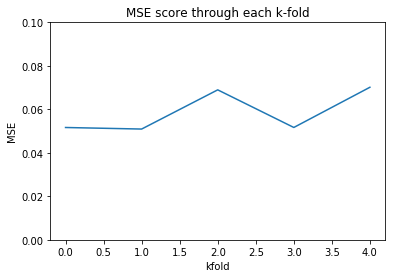

In [46]:
#plot out each mse score through each fold
plt.plot(mse_score)
axes = plt.gca()
axes.set_ylim([0,1])
plt.title('MSE score through each k-fold')
plt.xlabel('kfold')
plt.ylabel('MSE')
plt.ylim((0,0.1))

No handles with labels found to put in legend.


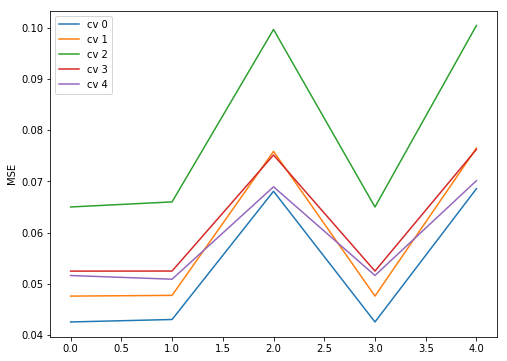

In [47]:
# Which alpha is the best for our model ? Looks like alpha= 0
plt.figure(figsize=(8,6))
#plt.ylim(0,0.1)
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
    
plt.legend()
plt.ylabel('MSE')
plt.show()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

est=Lasso(alpha=0)
est.fit(X_train,y_train)
#est.alpha

#print out the feature importance 
zipped=zip(X.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features

/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/windflower715/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[('bath', 0.24825151279413968),
 ('Doorman', 0.14287338851463502),
 ('Swimmingpool', 0.09251184935198882),
 ('Upper_west', 0.06976142952373929),
 ('Downtown', 0.05615248248334548),
 ('Laundryinunit', 0.038729688510020226),
 ('Dogsallowed', 0.03833628187297848),
 ('beds', 0.024128259750054802),
 ('Storage', 0.024081548275919993),
 ('Laundryinunit', 0.0025220015942519184),
 ('sqft', 0.00041894584651085007),
 ('hopscore', -0.004204874512345995),
 ('Storage', -0.00803098393485159),
 ('Light', -0.009013398610070526),
 ('Midtown', -0.010852910613248421),
 ('Catsallowed', -0.018483773835543102),
 ('Garden', -0.05805176635157857),
 ('Gym', -0.06150813487844615),
 ('Light', -0.06570772323351372),
 ('Liveinsuper', -0.06929514354430505),
 ('Upper_east', -0.0750299362827107),
 ('Parking', -0.07644314103653063),
 ('Laundryinbuilding', -0.11612177975845435),
 ('train', -0.13757642435463924),
 ('Uptown', -0.3173002390956235)]

Text(0,0.5,'y_test')

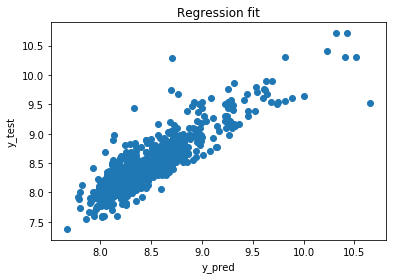

In [49]:
#now let's measure how our model performed! 
#regression fit
y_pred = est.predict(X_test)
plt.scatter(y_pred, y_test)
plt.title("Regression fit")
plt.xlabel('y_pred')
plt.ylabel('y_test')

Text(0,0.5,'residuals')

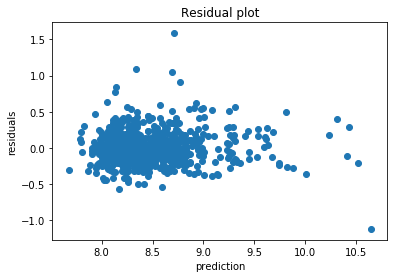

In [50]:
#Lasso resid plot 
resid = y_test-y_pred
plt.scatter(y_pred,resid)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")
#   plt.scatter(pred, res)
#     plt.title("Residual plot")
#     plt.xlabel("prediction")
#     plt.ylabel("residuals")

Text(0.5,1,'Normal Q-Q plot')

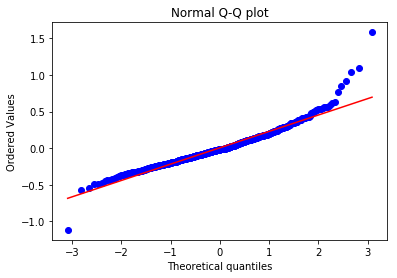

In [51]:
import scipy.stats as stats
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [52]:
dfupperwest= df[df['Upper_west'] ==1]
dfuppereast= df[df['Upper_east'] ==1]
# dfuppereast =dftrans[dftrans['neighborhood'] =='Upper_east']

Text(0.5,1,'upper west')

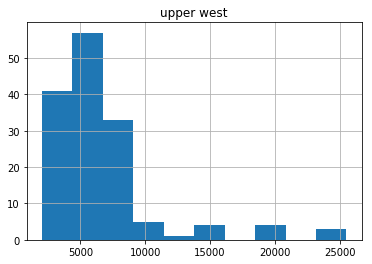

In [53]:
#take a closer look at the upper west and upper east rental price 

dfupperwest.monthlyrent.hist()
plt.title('upper west')

Text(0.5,1,'upper east')

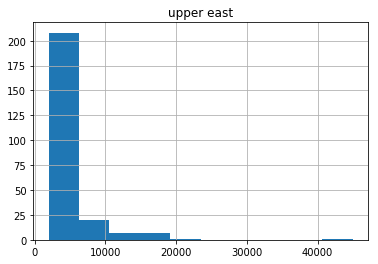

In [54]:
dfuppereast.monthlyrent.hist()
plt.title('upper east')

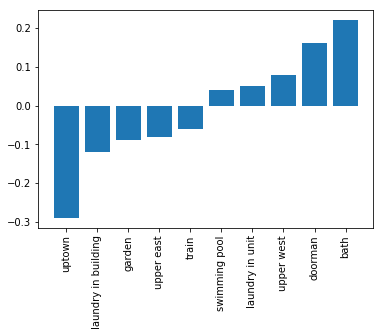

In [55]:
import matplotlib.pyplot as plt

D = {'bath':0.22, 'doorman': 0.16, 'upper west':0.08,'laundry in unit':0.05,'swimming pool':0.04,
    'uptown':-0.29,'laundry in building':-0.12,'garden':-0.09,'upper east':-0.08,'train':-0.06}

plt.bar(range(len(D)),sorted(D.values()), align='center')

labels = ['uptown','laundry in building','garden','upper east','train','swimming pool','laundry in unit',
         'upper west','doorman','bath']

plt.xticks([0,1,2,3,4,5,6,7,8,9],labels, rotation = 90)
plt.show()
